In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_score 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import clone
from sklearn import linear_model
#silence future warning message
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

In [2]:
item = pd.read_csv('items.csv')

In [3]:
df = pd.read_csv('sales_train.csv')

In [4]:
df = df.merge(item, left_on=df['item_id'], right_on = item['item_id'])

In [5]:
df.head()

,key_0,date,date_block_num,shop_id,item_id_x,item_price,item_cnt_day,item_name,item_id_y,item_category_id
0,22154,02.01.2013,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),22154,37
1,22154,23.01.2013,0,24,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),22154,37
2,22154,20.01.2013,0,27,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),22154,37
3,22154,02.01.2013,0,25,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),22154,37
4,22154,03.01.2013,0,25,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),22154,37


In [6]:
df.drop(['item_name','item_id_y'], axis =1, inplace = True)
df = df.rename(columns={'item_id_x': 'item_id'})

In [7]:
df = df.drop(['date'], axis = 1)

In [8]:
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]

rows_with_NaN.head(50)

,key_0,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id


In [9]:
def overview(dataframe):
    
    data_resumen = {'Valores Unicos':dataframe.nunique(),'No-Nulos': dataframe.notnull().sum(), 'Nulos': dataframe.isnull().sum(), 'Formato': dataframe.dtypes, 'Min': dataframe.min(), 'Max': dataframe.max()}
    resumen = pd.DataFrame(data=data_resumen)
    return resumen

In [10]:
overview(df)

,Valores Unicos,No-Nulos,Nulos,Formato,Min,Max
key_0,21807,2935849,0,int64,0.0,22169.0
date_block_num,34,2935849,0,int64,0.0,33.0
shop_id,60,2935849,0,int64,0.0,59.0
item_id,21807,2935849,0,int64,0.0,22169.0
item_price,19993,2935849,0,float64,-1.0,307980.0
item_cnt_day,198,2935849,0,float64,-22.0,2169.0
item_category_id,84,2935849,0,int64,0.0,83.0


In [11]:
#Get rid of outliers
df = df[(df['item_price']<100000) & (df['item_price']>=0)]
df = df[(df['item_cnt_day']<1000) & (df['item_cnt_day']>=0)]

# plot after outliers removal
#plot_features = ['item_price','item_cnt_day']
#for f in plot_features:
#   df.boxplot(f,f)


In [12]:
df2 = df.groupby(by = ['date_block_num','shop_id','item_category_id','item_id','item_price'])['item_cnt_day'].sum()

In [13]:
df2 = df2.reset_index(drop=False)
df2['total_sales'] = df2['item_price'] * df2['item_cnt_day']
df2.head()

,date_block_num,shop_id,item_category_id,item_id,item_price,item_cnt_day,total_sales
0,0,0,2,5572,1322.0,10.0,13220.0
1,0,0,2,5573,560.0,1.0,560.0
2,0,0,2,5575,806.0,4.0,3224.0
3,0,0,2,5576,2231.0,5.0,11155.0
4,0,0,2,5609,2381.0,1.0,2381.0


In [14]:
df2['item_id_avg_item_price'] = df2.groupby(['date_block_num','shop_id','item_id'])['total_sales'].transform('mean')


In [16]:
df3 = df2.groupby(by = ['date_block_num','shop_id','item_id'])['item_id_avg_item_price'].mean()

In [17]:
df3 = df3.reset_index(drop=False)
df3.head(6)

,date_block_num,shop_id,item_id,item_id_avg_item_price
0,0,0,32,1326.0
1,0,0,33,1041.0
2,0,0,35,247.0
3,0,0,43,221.0
4,0,0,51,128.5
5,0,0,61,195.0


In [18]:
df3['item_id_sum_item_cnt_day'] = df2.groupby(by = ['date_block_num','shop_id','item_id'])['item_cnt_day'].transform('sum')
df3['item_id_avg_item_cnt_day'] = df2.groupby(by = ['date_block_num','shop_id','item_id'])['item_cnt_day'].transform('mean')

In [19]:
df3.head()

,date_block_num,shop_id,item_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day
0,0,0,32,1326.0,10.0,10.0
1,0,0,33,1041.0,1.0,1.0
2,0,0,35,247.0,4.0,4.0
3,0,0,43,221.0,5.0,5.0
4,0,0,51,128.5,1.0,1.0


In [23]:
df3['shop_id_avg_item_price'] = df2.groupby(['date_block_num','shop_id'])['total_sales'].transform('mean')

df3['shop_id_avg_item_price'] = round(df3['shop_id_avg_item_price'],2)

In [24]:
df3['shop_id_sum_item_cnt_day'] = df2.groupby(['date_block_num','shop_id'])['item_cnt_day'].transform('sum')

In [25]:
df3.sample(20)

,date_block_num,shop_id,item_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day
206300,3,26,8765,1398.000,1.0,1.0,994.51,1541.0
746136,13,12,2254,1599.000,1.0,1.0,1819.93,1442.0
1514885,31,4,13246,718.000,1.0,1.0,2843.69,1338.0
283901,4,51,19529,1410.000,2.0,2.0,1069.43,2346.0
932095,17,7,6473,598.200,1.0,1.0,1436.19,1019.0
1227978,23,35,10379,1487.525,11.0,11.0,1739.22,1694.0
1396296,27,27,10253,299.000,1.0,1.0,2384.87,6061.0
1339482,25,57,1377,1298.740,1.0,1.0,1580.62,1652.0
1010949,18,52,3695,949.000,1.0,1.0,1943.31,6413.0
778793,13,51,21679,195.000,1.0,1.0,1842.03,3008.0


In [26]:
df3['shop_id_mean_item_cnt_day'] = df2.groupby(['date_block_num','shop_id'])['item_cnt_day'].transform('mean')
df3['shop_id_mean_item_cnt_day'] = round(df3['shop_id_mean_item_cnt_day'],2)
df3.head()

,date_block_num,shop_id,item_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_mean_item_cnt_day
0,0,0,32,1326.0,10.0,10.0,1228.84,5578.0,2.31
1,0,0,33,1041.0,1.0,1.0,1228.84,5578.0,2.31
2,0,0,35,247.0,4.0,4.0,1228.84,5578.0,2.31
3,0,0,43,221.0,5.0,5.0,1228.84,5578.0,2.31
4,0,0,51,128.5,1.0,1.0,1228.84,5578.0,2.31


In [27]:
df3['item_category_id_avg_item_price'] = df2.groupby(['date_block_num','shop_id','item_category_id'])['total_sales'].transform('mean')
df3['item_category_id_avg_item_price'] = round(df3['item_category_id_avg_item_price'],2)
df3.sample(20)

,date_block_num,shop_id,item_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_mean_item_cnt_day,item_category_id_avg_item_price
223147,3,42,19607,399.5,1.0,1.0,1542.52,3950.0,2.12,3823.77
939735,17,21,18701,199.0,1.0,1.0,1682.48,5584.0,2.50,747.78
323026,5,31,10558,298.0,1.0,1.0,359.87,1358.0,1.62,286.58
1395679,27,27,313,249.0,7.0,1.4,2384.87,6061.0,2.56,3075.82
238599,3,57,16169,598.0,1.0,1.0,1370.78,3986.0,1.96,776.63
1514072,31,2,20611,2249.0,1.0,1.0,2635.71,1109.0,2.03,599.00
1437880,28,42,15278,1099.0,1.0,1.0,1457.07,754.0,1.38,4188.00
1154295,22,10,7893,1560.0,2.0,2.0,2850.35,1360.0,1.82,2165.88
715623,12,31,16245,749.0,2.0,2.0,2464.71,4096.0,2.43,378.29
1121329,21,25,19370,798.0,1.0,1.0,1671.06,1985.0,1.73,1077.51


In [28]:
df3['item_category_id_sum_item_cnt_day'] = df2.groupby(['date_block_num','shop_id','item_category_id'])['item_cnt_day'].transform('sum')
df3['item_category_id_avg_item_cnt_day'] = df2.groupby(['date_block_num','shop_id','item_category_id'])['item_cnt_day'].transform('mean')
df3['item_category_id_sum_item_cnt_day'] = round(df3['item_category_id_sum_item_cnt_day'],2)
df3['item_category_id_avg_item_cnt_day'] = round(df3['item_category_id_avg_item_cnt_day'],2)
df3.sample(20)

,date_block_num,shop_id,item_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_mean_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day
1225091,23,31,15116,358.000,1.0,1.000000,1977.06,621.0,1.48,409.41,77.0,1.20
877079,15,54,20761,849.000,6.0,6.000000,2089.67,499.0,2.79,1906.00,16.0,1.78
334616,5,46,4907,4497.000,1.0,1.000000,1450.13,8482.0,2.44,2905.64,80.0,2.42
34679,0,30,12552,149.000,1.0,1.000000,1476.15,2824.0,1.92,661.73,126.0,1.38
678910,11,54,17243,399.000,1.0,1.000000,2306.75,3779.0,2.28,4993.43,51.0,2.43
835395,14,57,20253,149.000,1.0,1.000000,1724.11,1526.0,1.68,308.03,225.0,1.22
775338,13,46,21678,299.000,2.0,2.000000,1584.74,2836.0,1.94,447.45,551.0,1.68
427076,7,25,5208,2085.652,3.0,3.000000,1243.73,7231.0,2.26,498.46,1868.0,1.94
631632,11,15,9902,149.000,1.0,1.000000,2784.48,6463.0,3.03,8162.56,333.0,4.32
1340966,25,57,21679,149.000,2.0,2.000000,2532.52,2248.0,1.90,1308.67,8.0,1.33


In [29]:
df_test = df3

In [30]:
df_test.count()

date_block_num                       1608224
shop_id                              1608224
item_id                              1608224
item_id_avg_item_price               1608224
item_id_sum_item_cnt_day             1608224
item_id_avg_item_cnt_day             1608224
shop_id_avg_item_price               1608224
shop_id_sum_item_cnt_day             1608224
shop_id_mean_item_cnt_day            1608224
item_category_id_avg_item_price      1608224
item_category_id_sum_item_cnt_day    1608224
item_category_id_avg_item_cnt_day    1608224
dtype: int64

In [31]:
df_test.head()

,date_block_num,shop_id,item_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_mean_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day
0,0,0,32,1326.0,10.0,10.0,1228.84,5578.0,2.31,6211.25,53.0,3.31
1,0,0,33,1041.0,1.0,1.0,1228.84,5578.0,2.31,6211.25,53.0,3.31
2,0,0,35,247.0,4.0,4.0,1228.84,5578.0,2.31,6211.25,53.0,3.31
3,0,0,43,221.0,5.0,5.0,1228.84,5578.0,2.31,6211.25,53.0,3.31
4,0,0,51,128.5,1.0,1.0,1228.84,5578.0,2.31,6211.25,53.0,3.31


In [32]:
for i in range(1,4):

    
    df_test[f'item_id_avg_item_price(t-{i})'] = df_test['item_id_avg_item_price'].shift(i)
    df_test[f'item_id_sum_item_cnt_day(t-{i})'] = df_test['item_id_sum_item_cnt_day'].shift(i)
    df_test[f'item_id_avg_item_cnt_day(t-{i})'] = df_test['item_id_avg_item_cnt_day'].shift(i)
    df_test[f'shop_id_avg_item_price(t-{i})'] = df_test['shop_id_avg_item_price'].shift(i)
    df_test[f'shop_id_sum_item_cnt_day(t-{i})'] = df_test['shop_id_sum_item_cnt_day'].shift(i)
    df_test[f'shop_id_mean_item_cnt_day(t-{i})'] = df_test['shop_id_mean_item_cnt_day'].shift(i)
    df_test[f'item_category_id_avg_item_price(t-{i})'] = df_test['item_category_id_avg_item_price'].shift(i)
    df_test[f'item_category_id_sum_item_cnt_day(t-{i})'] = df_test['item_category_id_sum_item_cnt_day'].shift(i)
    df_test[f'item_category_id_avg_item_cnt_day(t-{i})'] = df_test['item_category_id_avg_item_cnt_day'].shift(i)
    

In [33]:
df_test = df_test.fillna(0)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1608224 entries, 0 to 1608223
Data columns (total 39 columns):
 #   Column                                  Non-Null Count    Dtype  
---  ------                                  --------------    -----  
 0   date_block_num                          1608224 non-null  int64  
 1   shop_id                                 1608224 non-null  int64  
 2   item_id                                 1608224 non-null  int64  
 3   item_id_avg_item_price                  1608224 non-null  float64
 4   item_id_sum_item_cnt_day                1608224 non-null  float64
 5   item_id_avg_item_cnt_day                1608224 non-null  float64
 6   shop_id_avg_item_price                  1608224 non-null  float64
 7   shop_id_sum_item_cnt_day                1608224 non-null  float64
 8   shop_id_mean_item_cnt_day               1608224 non-null  float64
 9   item_category_id_avg_item_price         1608224 non-null  float64
 10  item_category_id_sum_item_cnt_

In [69]:
X, y = df_test.drop(['item_id_sum_item_cnt_day'], axis = 1) , df_test['item_id_sum_item_cnt_day']

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=123)

In [79]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler


class XyScaler(BaseEstimator, TransformerMixin):
    """Standardize a training set of data along with a vector of targets."""

    def __init__(self):
        self.X_scaler = StandardScaler()
        self.y_scaler = StandardScaler()
        
    def fit(self, X, y, *args, **kwargs):
        """Fit the scaler to data and a target vector."""
        self.X_scaler.fit(X)
        self.y_scaler.fit(y.values.reshape(-1, 1))
        return self
    
    def transform(self, X, y, *args, **kwargs):
        """Transform a new set of data and target vector."""
        return (self.X_scaler.transform(X),
                self.y_scaler.transform(y.values.reshape(-1, 1)))

    def inverse_transform(self, X, y, *args, **kwargs):
        """Tranform from a scaled representation back to the original scale."""
        return (self.X_scaler.inverse_transform(X),
                self.y_scaler.inverse_transform(y.values.reshape(-1, 1)))

In [71]:
mdl1 = Lasso(alpha =0.01).fit(X, y)
y_pred = mdl1.predict(X)
mean_squared_error(y, y_pred), r2_score(y, y_pred)

/Users/jiguzmans/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14203443.317338677, tolerance: 26676.52759065662
  model = cd_fast.enet_coordinate_descent(


(17.82734714289144, 0.8925258640424618)

In [80]:
mdl2 = Lasso(alpha =0.01).fit(X_train, y_train)
y_pred = mdl1.predict(X_test)
mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)

/Users/jiguzmans/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10771714.416326595, tolerance: 20725.56450865096
  model = cd_fast.enet_coordinate_descent(


(21.313969869539765, 0.8847992367200026)

In [81]:
def cv(X_train, y_train, base_estimator, n_folds, random_seed=154):
    """Estimate the in- and out-of-sample error of a model using cross
    validation.
    
    Parameters
    ----------
    
    X_train: np.array
      Matrix of predictors.
      
    y_train: np.array
      Target array.
      
    base_estimator: sklearn model object.
      The estimator to fit.  Must have fit and predict methods.
      
    n_folds: int
      The number of folds in the cross validation.
      
    random_seed: int
      A seed for the random number generator, for repeatability.
    
    Returns
    -------
      
    train_cv_errors, test_cv_errors: tuple of arrays
      The training and testing errors for each fold of cross validation.
    """
    kf = KFold(n_splits=n_folds, random_state=random_seed)
    train_cv_errors, valid_cv_errors = np.empty(n_folds), np.empty(n_folds)

    for idx, (train_idx, valid_idx) in enumerate(kf.split(X_train)):
        # Split into train and test
        X_cv_train, y_cv_train = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_cv_valid, y_cv_valid = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

        # Standardize data, fit on training set, transform training and test.
        scaler = XyScaler()
        scaler.fit(X_cv_train, y_cv_train)
        X_cv_train_std, y_cv_train_std = scaler.transform(X_cv_train, y_cv_train)
        X_cv_valid_std, y_cv_valid_std = scaler.transform(X_cv_valid, y_cv_valid)

        # Fit ridge regression to training data.
        mdl = clone(base_estimator)
        mdl.fit(X_cv_train_std, y_cv_train_std)

        # Make predictions.
        y_cv_train_pred = mdl.predict(X_cv_train_std)
        y_cv_valid_pred = mdl.predict(X_cv_valid_std)

        # Calculate MSE.
        train_cv_errors[idx] = mean_squared_error(y_cv_train_std, y_cv_train_pred)
        valid_cv_errors[idx] = mean_squared_error(y_cv_valid_std, y_cv_valid_pred)
    return train_cv_errors, valid_cv_errors

In [82]:
train_cv_errors, valid_cv_errors = cv(X_train, y_train, base_estimator=Lasso(alpha=0.01), n_folds=5, random_seed=154)

In [83]:
print(f"Training CV error: {train_cv_errors.mean():.2f}")
print(f"Test CV error: {valid_cv_errors.mean():.2f}")

Training CV error: 0.11
Test CV error: 0.11


In [84]:
def train_at_various_alphas(X_train, y_train, model, alphas, n_folds, random_seed, **kwargs):
    """Train a regularized regression model using cross validation at various
    values of alpha.
    
    Parameters
    ----------
    
    X_train: np.array
      Matrix of predictors.
      
    y_train: np.array
      Target array.
      
    model: sklearn model class
      A class in sklearn that can be used to create a regularized regression
      object.  Options are `Ridge` and `Lasso`.
      
    alphas: numpy array
      An array of regularization parameters.
      
    n_folds: int
      Number of cross validation folds.
      
    Returns
    -------
    
    cv_errors_train, cv_errors_valid: tuple of DataFrame
      DataFrames containing the training and validating errors for each value of
      alpha and each cross validation fold.  Each row represents a CV fold, and
      each column a value of alpha.
    """
    cv_errors_train = pd.DataFrame(np.empty(shape=(n_folds, len(alphas))),
                                     columns=alphas)
    cv_errors_valid = pd.DataFrame(np.empty(shape=(n_folds, len(alphas))),
                                        columns=alphas)
    for alpha in alphas:
        train_cv_errors, valid_cv_errors = cv(X_train, y_train, base_estimator=model(alpha=alpha, **kwargs), n_folds=n_folds, random_seed=random_seed)
        cv_errors_train.loc[:,alpha] = train_cv_errors
        cv_errors_valid.loc[:,alpha] = valid_cv_errors
    return cv_errors_train, cv_errors_valid

In [124]:
alphas=np.logspace(-4,1, num=50)
cv_errors_train, cv_errors_valid = train_at_various_alphas(X_train, y_train, model=Lasso, alphas=alphas, n_folds=5, random_seed=154)

In [125]:
train_means, valid_means = cv_errors_train.mean(axis=0), cv_errors_valid.mean(axis=0)

In [126]:
alphas = valid_means.index
optimal_idx = np.argmin(valid_means.values)
optimal_alpha = alphas[optimal_idx]

In [127]:
#method 2:
optimal_alpha = valid_means.idxmin()
optimal_alpha

0.0001

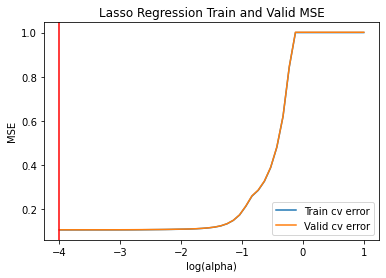

In [132]:
fig, ax = plt.subplots()
ax.plot(np.log10(alphas), train_means, label='Train cv error')
ax.plot(np.log10(alphas), valid_means, label='Valid cv error')
ax.axvline(np.log10(valid_means.idxmin()), color='red')
ax.legend()
ax.set_title('Lasso Regression Train and Valid MSE')
ax.set_xlabel('log(alpha)')
ax.set_ylabel('MSE');

In [92]:
def model_selection(X_train, y_train, model, alphas=None):
    '''select Ridge/Lasso/LinearRegression model with optimal alpha
    Parameters:
    -----------
    model: either one in [Ridge, Lasso, LinearRegression]
    alphas (np.array or list): alpha values for Ridge or Lasso
    '''
    scaler = XyScaler()
    scaler.fit(X_train, y_train)
    X_train_std, y_train_std = scaler.transform(X_train, y_train)
    X_test_std, y_test_std = scaler.transform(X_test, y_test)
    if model is not LinearRegression:
        cv_errors_train, cv_errors_valid = train_at_various_alphas(X_train, y_train, model=model, alphas=alphas, n_folds=5, random_seed=154)
        train_means, valid_means = cv_errors_train.mean(axis=0), cv_errors_valid.mean(axis=0)
        optimal_alpha = valid_means.idxmin()
        mdl = model(alpha=optimal_alpha).fit(X_train_std, y_train_std)
    else: # model is LinearRegression:
        mdl = model().fit(X_train_std, y_train_std)
    y_pred_std = mdl.predict(X_test_std)
    mse = mean_squared_error(y_test_std, y_pred_std)
    return mse, model

In [93]:
mse_ridge, model_ridge = model_selection(X_train=X_train, y_train=y_train, model=Ridge, alphas=np.logspace(-2,4, num=50))
mse_lasso, model_lasso = model_selection(X_train=X_train, y_train=y_train, model=Lasso, alphas=np.logspace(-3,1, num=50))
mse_linear, model_linear = model_selection(X_train=X_train, y_train=y_train, model=LinearRegression)

In [94]:
print(f'Ridge rss={mse_ridge**.5:.3f}')
print(f'Lasso rss={mse_lasso**.5:.3f}')
print(f'LinearRegression rss={mse_linear**.5:.3f}')

Ridge rss=0.365
Lasso rss=0.365
LinearRegression rss=0.365


In [129]:
# build a list of fitted models
models = []
for alpha in alphas:
    scaler = XyScaler()
    scaler.fit(X_train, y_train)
    X_train_std, y_train_std = scaler.transform(X_train, y_train)
    model = Lasso(alpha=alpha)
    model.fit(X_train_std, y_train_std)
    models.append(model)

In [130]:
df0 = pd.DataFrame(np.empty(shape=(len(alphas), X_train.shape[1])), 
                  index=alphas,
                  columns=X_train.columns
                 )
for i, model in enumerate(models):
    df0.iloc[i] = model.coef_ #each alpha corresponds to each row (of features/model coefficients)

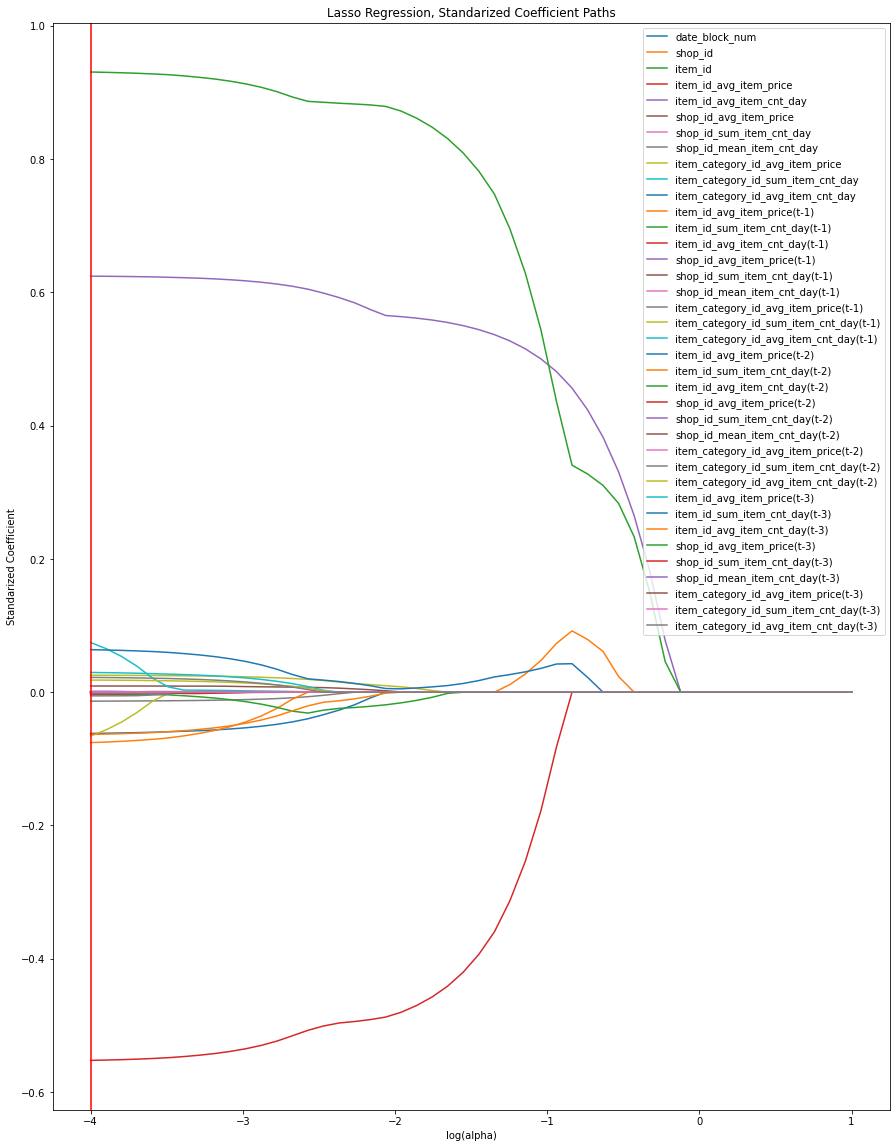

In [131]:
fig, ax = plt.subplots(figsize=(15,20))
for col in X_train.columns:
    path = df0.loc[:, col] # each col of df corresponds to each path (across diff alphas)
    ax.plot(np.log10(alphas), path, label=col)
ax.axvline(np.log10(optimal_alpha), color='red')
ax.legend()
ax.set_title('Lasso Regression, Standarized Coefficient Paths')
ax.set_xlabel('log(alpha)')
ax.set_ylabel('Standarized Coefficient');